### základní informace - zdroje

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

### Aktuální nabídku bytů ve Zlíně - pronájem
     URL odkaz bytu
     Rozměry bytu (v m²)
     Dispozice bytu (1+1, 2+kk, atp.)
     Cena bytu (v Kč)
     Lokace bytu (Ulice + město)

### 1. WebScraping

In [6]:
import requests
import time
import pandas as pd
import re

# --- NASTAVENÍ ---
MOJE_JMENO = "Veronika_Sura" 
MESTO_ID = 3405  # ID pro Zlín
VYSTUPNI_SOUBOR = f"{MOJE_JMENO}_surova_data.csv"

def scrapuj_pronajmy_zlin():
    vsechny_inzeraty = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    }

    # Projdeme prvních 5 stránek (včetně pagination)
    for strana in range(1, 6):
        # Parametr category_type_cb=2 znamená PRONÁJEM
        url = f"https://www.sreality.cz/api/cs/v2/estates?category_main_cb=1&category_type_cb=2&region_entity_id={MESTO_ID}&region_entity_type=city&per_page=20&page={strana}"
        
        print(f"Stahuji pronájmy - strana {strana}...")
        
        try:
            response = requests.get(url, headers=headers)
            if response.status_code != 200:
                break
            
            data = response.json()
            inzeraty = data.get('_embedded', {}).get('estates', [])
            
            if not inzeraty:
                break

            for inz in inzeraty:
                nazev = inz.get('name', '')  # např. "Pronájem bytu 2+kk 50 m²"
                lokace = inz.get('locality', '')
                # U pronájmů je cena obvykle měsíční nájem
                cena = inz.get('price', 0)
                
                hash_id = inz.get('hash_id')
                seo = inz.get('seo', {}).get('ad_path', '')
                # Upravená URL na /pronajem/
                url_bytu = f"https://www.sreality.cz/detail/pronajem/byt/{seo}/{hash_id}"

                # Extrakce dispozice a metrů pomocí regulárních výrazů
                dispozice = re.search(r'\d\+\w+', nazev)
                metry = re.search(r'(\d+)\s+m²', nazev)

                vsechny_inzeraty.append({
                    'url': url_bytu,
                    'rozmery_m2': metry.group(1) if metry else "N/A",
                    'dispozice': dispozice.group(0) if dispozice else "N/A",
                    'cena': cena,
                    'lokace': lokace
                })
            
            time.sleep(1.5) # Povinná pauza mezi requesty

        except Exception as e:
            print(f"Chyba: {e}")
            break

    # Uložení do CSV
    if vsechny_inzeraty:
        df = pd.DataFrame(vsechny_inzeraty)
        df.to_csv(VYSTUPNI_SOUBOR, index=False, encoding='utf-8-sig')
        print(f"Hotovo! Staženo {len(df)} pronájmů do souboru {VYSTUPNI_SOUBOR}")
    else:
        print("Nepodařilo se stáhnout žádná data.")

# Spustit znovu scraping
scrapuj_pronajmy_zlin()

Stahuji pronájmy - strana 1...
Stahuji pronájmy - strana 2...
Stahuji pronájmy - strana 3...
Stahuji pronájmy - strana 4...
Stahuji pronájmy - strana 5...
Hotovo! Staženo 103 pronájmů do souboru Veronika_Sura_surova_data.csv


### 2. Datová analýza - ETL proces (Extract, Transform, Load)

In [7]:
import pandas as pd

# 1. název souboru 
soubor = "Veronika_Sura_surova_data.csv"

# 2. Načtení souboru do proměnné df (DataFrame)
#Používáme encoding='utf-8-sig', aby se správně načetla čeština
df = pd.read_csv(soubor, encoding='utf-8-sig')

# 3. Zobrazení prvních 20 řádků pro kontrolu
print("Ukázka stažených dat:")
display(df.head(20))

# 4. Základní informace o datech (počet řádků, datové typy)
print("\nInformace o struktuře tabulky:")
df.info()

Ukázka stažených dat:


,url,rozmery_m2,dispozice,cena,lokace
0,https://www.sreality.cz/detail/pronajem/byt//1...,31,1+1,8000,"Severovýchod, Zábřeh"
1,https://www.sreality.cz/detail/pronajem/byt//4...,78,3+1,26000,"Údolní, Praha 4 - Braník"
2,https://www.sreality.cz/detail/pronajem/byt//3...,50,2+kk,25000,"Tachovské náměstí, Praha 3 - Žižkov"
3,https://www.sreality.cz/detail/pronajem/byt//3...,27,1+kk,15500,"Holečkova, Praha 5 - Smíchov"
4,https://www.sreality.cz/detail/pronajem/byt//2...,74,2+1,24000,"Na Zatlance, Praha - Smíchov"
5,https://www.sreality.cz/detail/pronajem/byt//3...,60,3+1,13000,"Horní Valy, Hodonín"
6,https://www.sreality.cz/detail/pronajem/byt//2...,56,2+kk,42000,"U Sluncové, Praha 8 - Karlín"
7,https://www.sreality.cz/detail/pronajem/byt//5...,61,2+1,30000,"Benediktská, Praha 1 - Staré Město"
8,https://www.sreality.cz/detail/pronajem/byt//2...,60,2+1,22900,"Cíglerova, Praha 9 - Černý Most"
9,https://www.sreality.cz/detail/pronajem/byt//3...,52,2+kk,19000,"Vojkovice, okres Mělník"



Informace o struktuře tabulky:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   url         103 non-null    object
 1   rozmery_m2  103 non-null    int64 
 2   dispozice   103 non-null    object
 3   cena        103 non-null    int64 
 4   lokace      103 non-null    object
dtypes: int64(2), object(3)
memory usage: 4.2+ KB


In [4]:
import pandas as pd
import numpy as np

# Definice názvů souborů
jmeno_studenta = "Veronika_Sura"
soubor_surova = f"{jmeno_studenta}_surova_data.csv"
soubor_zdrojova = f"{jmeno_studenta}_zdrojova_data.csv"

# 1. Načtení surových dat
df = pd.read_csv(soubor_surova, encoding='utf-8-sig')

# 2. Základní informace o datech
print("--- ZÁKLADNÍ INFORMACE O NAČTENÝCH DATECH ---")
print(f"Počet řádků: {df.shape[0]}")
print(f"Počet sloupců: {df.shape[1]}")
print("\nDatové typy sloupců:")
print(df.dtypes)
print("\nNáhled dat:")
display(df.head())

--- ZÁKLADNÍ INFORMACE O NAČTENÝCH DATECH ---
Počet řádků: 104
Počet sloupců: 5

Datové typy sloupců:
url           object
rozmery_m2     int64
dispozice     object
cena           int64
lokace        object
dtype: object

Náhled dat:


,url,rozmery_m2,dispozice,cena,lokace
0,https://www.sreality.cz/detail/pronajem/byt//2...,25,1+kk,9000,"Přáslavice, okres Olomouc"
1,https://www.sreality.cz/detail/pronajem/byt//6...,73,3+kk,18610,"U Solných mlýnů, Olomouc - Holice"
2,https://www.sreality.cz/detail/pronajem/byt//1...,30,1+kk,11000,"Nádražní, Příbram - Příbram IV"
3,https://www.sreality.cz/detail/pronajem/byt//2...,70,2+1,13800,"Jablonec nad Jizerou, okres Semily"
4,https://www.sreality.cz/detail/pronajem/byt//2...,65,2+kk,20000,"Štěpařská, Praha 5 - Hlubočepy"


### 3. Datová analýza - analýza dat


In [8]:
# --- ČIŠTĚNÍ DAT ---

# 1. Převod datových typů na číselné
# errors='coerce' způsobí, že pokud narazí na text (např. "N/A"), nahradí ho hodnotou NaN (not a number)
df['rozmery_m2'] = pd.to_numeric(df['rozmery_m2'], errors='coerce')
df['cena'] = pd.to_numeric(df['cena'], errors='coerce')

# 2. Zpracování chybějících hodnot (NaN)
# Zjištění počtu chybějících hodnot
print("\nPočet chybějících hodnot v jednotlivých sloupcích:")
print(df.isnull().sum())

# ROZHODNUTÍ: odstranit řádky, kde chybí cena nebo rozměr.
# Zdůvodnění: Pro analýzu trhu s byty jsou inzeráty bez ceny nebo plochy nepoužitelné 
# , mohlo by zkreslit výsledky.
df = df.dropna(subset=['cena', 'rozmery_m2'])

# 3. Rozdělení lokace na samostatné sloupce (Ulice a Město)
# Sreality obvykle vrací lokaci ve formátu "Ulice, Město - Čtvrť" nebo jen "Město - Čtvrť"
# Použijeme rozdělení podle čárky nebo pomlčky.
def rozdel_lokaci(row):
    text = row['lokace']
    if ',' in text:
        casti = text.split(',', 1)
        ulice = casti[0].strip()
        mesto = casti[1].strip()
    else:
        mesto = text.strip()
    return pd.Series([ulice, mesto])

df[['Ulice', 'Město']] = df.apply(rozdel_lokaci, axis=1)

print("\nČištění dat dokončeno.")


Počet chybějících hodnot v jednotlivých sloupcích:
url           0
rozmery_m2    0
dispozice     0
cena          0
lokace        0
dtype: int64

Čištění dat dokončeno.


In [6]:
# --- EXPORT A STATISTIKA ---

# 1. Zobrazení základní statistiky
print("\n--- STATISTIKA VYČIŠTĚNÝCH DAT ---")
print(f"Konečný počet inzerátů k analýze: {len(df)}")
print("\nZákladní statistické ukazatele (Cena a Rozměry):")
display(df[['cena', 'rozmery_m2']].describe())

# 2. Export do zdrojová_data.csv
df.to_csv(soubor_zdrojova, index=False, encoding='utf-8-sig')

print(f"\nZprocesovaná data byla úspěšně uložena do: {soubor_zdrojova}")

# Finální náhled vyčištěné tabulky
display(df.head())


--- STATISTIKA VYČIŠTĚNÝCH DAT ---
Konečný počet inzerátů k analýze: 104

Základní statistické ukazatele (Cena a Rozměry):


,cena,rozmery_m2
count,104.000000,104.000000
mean,37283.201923,78.548077
std,29998.408316,45.076608
min,7750.000000,16.000000
25%,17875.000000,44.000000
50%,27600.000000,65.000000
75%,48250.000000,100.250000
max,180000.000000,228.000000



Zprocesovaná data byla úspěšně uložena do: Veronika_Sura_zdrojova_data.csv


,url,rozmery_m2,dispozice,cena,lokace,Ulice,Město
0,https://www.sreality.cz/detail/pronajem/byt//2...,25,1+kk,9000,"Přáslavice, okres Olomouc",Přáslavice,okres Olomouc
1,https://www.sreality.cz/detail/pronajem/byt//6...,73,3+kk,18610,"U Solných mlýnů, Olomouc - Holice",U Solných mlýnů,Olomouc - Holice
2,https://www.sreality.cz/detail/pronajem/byt//1...,30,1+kk,11000,"Nádražní, Příbram - Příbram IV",Nádražní,Příbram - Příbram IV
3,https://www.sreality.cz/detail/pronajem/byt//2...,70,2+1,13800,"Jablonec nad Jizerou, okres Semily",Jablonec nad Jizerou,okres Semily
4,https://www.sreality.cz/detail/pronajem/byt//2...,65,2+kk,20000,"Štěpařská, Praha 5 - Hlubočepy",Štěpařská,Praha 5 - Hlubočepy


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nastavení vzhledu grafů
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Načtení vyčištěných dat
jmeno_studenta = "Veronika_Sura"
df = pd.read_csv(f"{jmeno_studenta}_zdrojova_data.csv", encoding='utf-8-sig')

print("Data byla úspěšně načtena. Počet záznamů:", len(df))

Data byla úspěšně načtena. Počet záznamů: 104


In [10]:
avg_price = df['cena'].mean()
median_price = df['cena'].median()

print(f"Průměrná cena nájmu: {avg_price:.0f} Kč")
print(f"Medián ceny nájmu: {median_price:.0f} Kč")
print(f"Rozdíl: {abs(avg_price - median_price):.0f} Kč")
# Poznámka: Pokud je průměr vyšší než medián, znamená to, že pár luxusních bytů táhne průměr nahoru.

Průměrná cena nájmu: 37283 Kč
Medián ceny nájmu: 27600 Kč
Rozdíl: 9683 Kč


In [ ]:
# Seskupení dat podle dispozice
dispozice_stats = df.groupby('dispozice').agg({
    'cena': 'mean',
    'rozmery_m2': 'mean'
}).sort_values(by='cena')


In [13]:
dispozice_stats

,cena,rozmery_m2
dispozice,,
1+1,10533.333333,37.666667
1+kk,17801.333333,32.777778
2+1,22010.000000,63.800000
2+kk,28503.357143,60.107143
3+1,34241.666667,95.166667
3+kk,47590.333333,93.466667
4+kk,66414.285714,117.714286
4+1,69857.142857,156.000000
5+1,107145.000000,171.250000


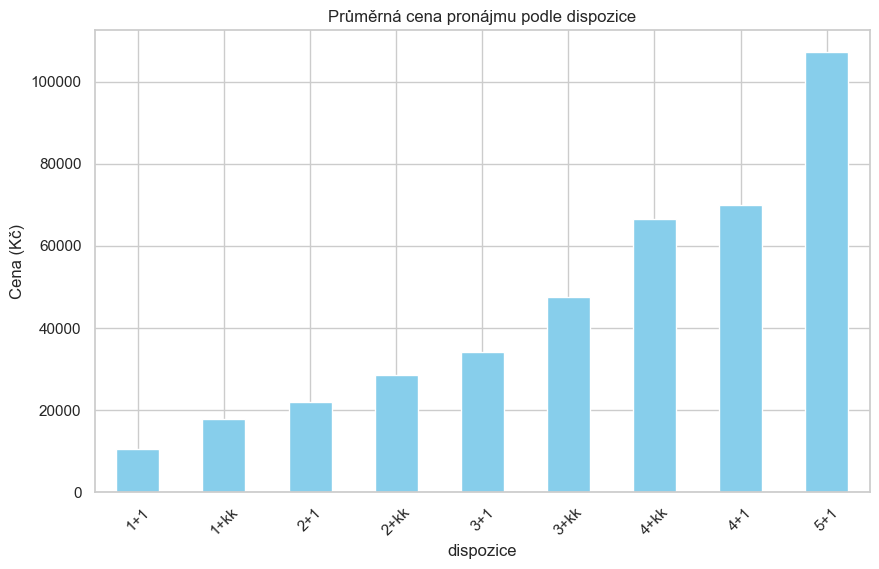

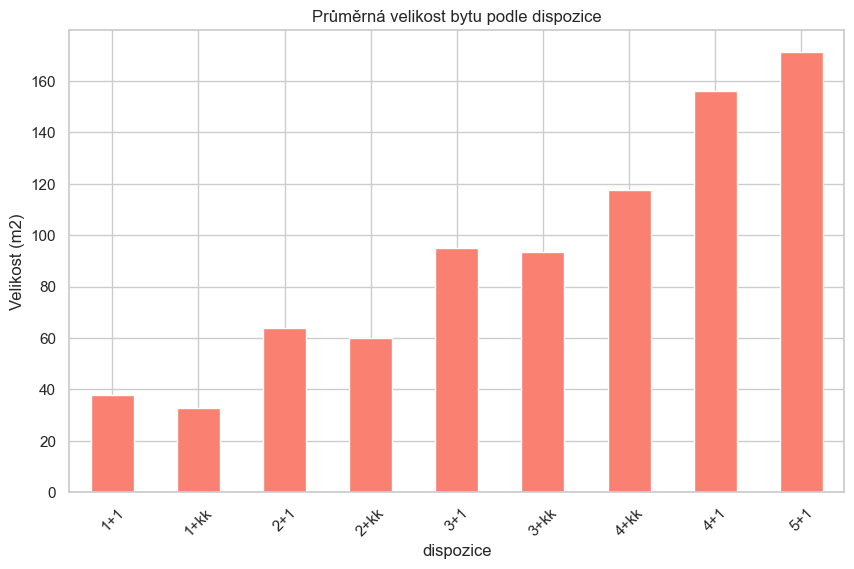

In [14]:
# Graf průměrné ceny
dispozice_stats['cena'].plot(kind='bar', color='skyblue')
plt.title('Průměrná cena pronájmu podle dispozice')
plt.ylabel('Cena (Kč)')
plt.xticks(rotation=45)
plt.show()

# Graf průměrné velikosti
dispozice_stats['rozmery_m2'].plot(kind='bar', color='salmon')
plt.title('Průměrná velikost bytu podle dispozice')
plt.ylabel('Velikost (m2)')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Definice "dražšího" bytu
prumer = df['cena'].mean()
df_drahe = df[df['cena'] > prumer]

# Top 5 nejdražších ulic (průměrná cena v ulici)
top_ulice = df.groupby('Ulice')['cena'].mean().sort_values(ascending=False).head(5)

print("Top 5 nejdražších ulic (průměrná cena):")
print(top_ulice)

Top 5 nejdražších ulic (průměrná cena):
Ulice
Milevská         180000.0
náměstí Míru     136996.0
Laubova          114800.0
Ibsenova         105792.0
Jana Masaryka     99900.0
Name: cena, dtype: float64


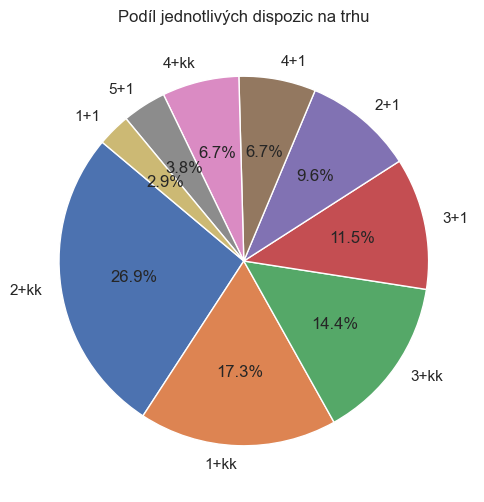

Nejčastěji inzerovaná dispozice je: 2+kk


In [ ]:
counts = df['dispozice'].value_counts()
nejčastější = counts.idxmax()

counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Podíl jednotlivých dispozic na trhu')
plt.ylabel('') # Odstraní popisek osy y
plt.show()

print(f"Nejčastěji inzerovaná dispozice je: {nejčastější}")
# často to bývají byty 2+kk nebo 2+1, protože jsou nejuniverzálnější 
# – vhodné pro jednotlivce, páry i malé rodiny, a zároveň dostupné.

In [18]:
nad_20k = df[df['cena'] > 20000]
maly_luxus = nad_20k[nad_20k['dispozice'].isin(['2+kk', '2+1', '1+kk', '1+1'])]

print(f"Počet inzerátů nad 20 000 Kč: {len(nad_20k)}")
print(f"Z toho malých bytů (do 2+1): {len(maly_luxus)}")

if not maly_luxus.empty:
    display(maly_luxus[['url', 'cena', 'dispozice', 'Ulice']])

Počet inzerátů nad 20 000 Kč: 70
Z toho malých bytů (do 2+1): 32


,url,cena,dispozice,Ulice
7,https://www.sreality.cz/detail/pronajem/byt//1...,21000,1+kk,Lípová
8,https://www.sreality.cz/detail/pronajem/byt//1...,23000,2+kk,Máchova
14,https://www.sreality.cz/detail/pronajem/byt//2...,28000,2+kk,Lípová
18,https://www.sreality.cz/detail/pronajem/byt//1...,24000,2+kk,Roháčova
20,https://www.sreality.cz/detail/pronajem/byt//3...,22990,1+kk,Podle náhonu
21,https://www.sreality.cz/detail/pronajem/byt//2...,28600,1+kk,Vrbenského
22,https://www.sreality.cz/detail/pronajem/byt//1...,21000,2+kk,Pekařova
27,https://www.sreality.cz/detail/pronajem/byt//2...,35000,2+kk,K Sídlišti
31,https://www.sreality.cz/detail/pronajem/byt//5...,21000,2+kk,Vojtova
32,https://www.sreality.cz/detail/pronajem/byt//2...,29500,2+kk,U Zvonařky


In [20]:
rozptyl = df.groupby('dispozice')['cena'].agg(['min', 'max'])
rozptyl['rozdil'] = rozptyl['max'] - rozptyl['min']
rozptyl

,min,max,rozdil
dispozice,,,
1+1,8600,12000,3400
1+kk,7750,29184,21434
2+1,13800,75000,61200
2+kk,8490,53504,45014
3+1,13000,85000,72000
3+kk,15900,180000,164100
4+1,59000,79000,20000
4+kk,30000,114800,84800
5+1,77824,136996,59172


In [ ]:
# Graf rozptylu
rozptyl[['min', 'max']].plot(kind='bar')
plt.title('Minimální a maximální cena podle dispozice')
plt.ylabel('Cena (Kč)')
plt.show()

nejvetsi_rozptyl = rozptyl['rozdil'].idxmax()
print(f"Největší rozptyl cen má dispozice: {nejvetsi_rozptyl}")